In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size = 100

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

In [7]:
model = CNN()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

In [8]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        pred = model(data)
        loss = loss_function(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target, top_class)
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev)
                dev_loss = loss_function(dev_pred, target_dev)
                dev_losss += dev_loss.item()

                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev, dev_top_class)
        
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(losses/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

Epoch: 1/50..  Training Loss: 1.730..  Validation Loss: 1.459..  Training Accuracy: 0.366..  Validation Accuracy: 0.473
Epoch: 5/50..  Training Loss: 1.178..  Validation Loss: 1.081..  Training Accuracy: 0.580..  Validation Accuracy: 0.613
Epoch: 10/50..  Training Loss: 0.964..  Validation Loss: 0.917..  Training Accuracy: 0.659..  Validation Accuracy: 0.675
Epoch: 15/50..  Training Loss: 0.852..  Validation Loss: 0.872..  Training Accuracy: 0.698..  Validation Accuracy: 0.695
Epoch: 20/50..  Training Loss: 0.779..  Validation Loss: 0.834..  Training Accuracy: 0.723..  Validation Accuracy: 0.708
Epoch: 25/50..  Training Loss: 0.726..  Validation Loss: 0.837..  Training Accuracy: 0.740..  Validation Accuracy: 0.711
Epoch: 30/50..  Training Loss: 0.683..  Validation Loss: 0.817..  Training Accuracy: 0.754..  Validation Accuracy: 0.718
Epoch: 35/50..  Training Loss: 0.658..  Validation Loss: 0.817..  Training Accuracy: 0.762..  Validation Accuracy: 0.719
Epoch: 40/50..  Training Loss: 0.6

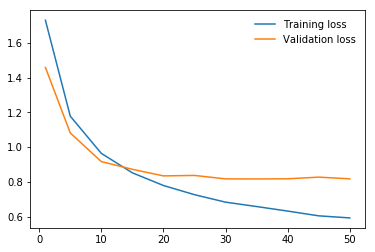

In [9]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

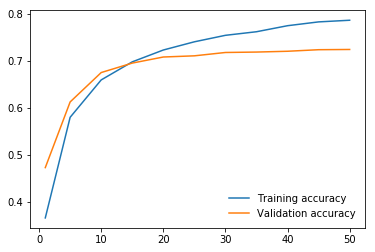

In [10]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [11]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test, top_class_test)
print(acc_test/iter_3)

0.7213
